# Homework 1. Likelihood-based models

- Task 1 (5 points): Warmup
- **Task 2 (10 points): PixelCNN**
- Task 3 (10 points): Conditional PixelCNN
- Task 4 (10 points): RealNVP
- \* Bonus (10+++ points)

## Task 2. PixelCNN on Shapes and MNIST

In this part, implement a simple PixelCNN architecture to model binary MNIST and shapes images

Recap:

$$Mask_a
=
\begin{bmatrix}
1 & 1 & 1 \\
1 & 0 & 0 \\
0 & 0 & 0 \\
\end{bmatrix}$$

$$Mask_b
=
\begin{bmatrix}
1 & 1 & 1 \\
1 & 1 & 0 \\
0 & 0 & 0 \\
\end{bmatrix}$$

We recommend the following network design:
* A $7 \times 7$ masked type A convolution
* $5$ $7 \times 7$ masked type B convolutions
* $2$ $1 \times 1$ masked type B convolutions
* Appropriate ReLU nonlinearities in-between
* 64 convolutional filters

And the following hyperparameters:
* Batch size 128
* Learning rate $10^{-3}$
* 10 epochs
* Adam Optimizer (this applies to all PixelCNN models trained in future parts)

Your model should output logits, after which you could apply a sigmoid over 1 logit, or a softmax over two logits (either is fine). It may also help to scale your input to $[-1, 1]$ before running it through the network. 

Training on the shapes dataset should be quick, and MNIST should take around 10 minutes

**You will provide these deliverables**

1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
import math
from sklearn.model_selection import train_test_split
import random

%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
import pickle
from torchvision.utils import make_grid


def show_samples(samples, fname=None, nrow=10, title='Samples'):
    samples = (torch.FloatTensor(samples)).permute(0, 3, 1, 2)
    grid_img = make_grid(samples, nrow=nrow)
    plt.figure()
    plt.title(title)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')

    if fname is not None:
        savefig(fname)
    else:
        plt.show()
        

def load_data(fname, binarize=True, include_labels=False):
    with open(fname, 'rb') as data_file:
        data = pickle.load(data_file)
    
    if include_labels:
        return (data['train'] > 127.5), (data['test'] > 127.5), data['train_labels'], data['test_labels']
    
    return (data['train'] > 127.5), (data['test'] > 127.5)


class SimpleDataset(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = X
        self.y = y
        
        assert len(X) == len(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

First of all, we need to modify `Conv2d` with masking

In [3]:
class MaskedConv2D(nn.Conv2d):
    def __init__(self, mask_type, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.register_buffer('mask', torch.zeros_like(self.weight))
        self.create_mask(mask_type)
    
    def forward(self, x):
        """
        x: (N, C_in, H_in, W_in) torch.Tensor
        Returns
          - out (N, C_out, H_out, W_out) should be conv2d(x, weight * mask) + bias 
        """
        return F.conv2d(x, self.weight * self.mask, self.bias, padding=(self.kernel_size[0] // 2))
    
    def create_mask(self, mask_type):
        assert mask_type == 'A' or mask_type == 'B'
        k = self.kernel_size[0]
        half_k = k // 2 if k % 2 else k // 2 - 1
        self.mask[:, :, :half_k, :] = 1
        self.mask[:, :, half_k, :half_k] = 1
        if mask_type == 'B':
            self.mask[:, :, half_k, half_k] = 1

In [4]:
convA = MaskedConv2D('A', 1, 1, kernel_size=3)
convB = MaskedConv2D('B', 1, 1, kernel_size=3)
assert np.allclose(convA.mask.view(-1), [1., 1., 1., 1., 0., 0., 0., 0., 0.], atol=1e-6)
assert np.allclose(convB.mask.view(-1), [1., 1., 1., 1., 1., 0., 0., 0., 0.], atol=1e-6)

In [5]:
from re import X
class PixelCNN(nn.Module):
    def __init__(self, input_shape, n_colors=2, n_filters=64,
               kernel_size=7, n_layers=5):
        super().__init__()
        assert n_layers >= 2
        n_channels = input_shape[0]
        
        self.input_shape = input_shape
        self.n_channels = n_channels
        self.n_colors = n_colors

        self.blockA = nn.Sequential(
            MaskedConv2D('A', self.n_channels, n_filters, kernel_size=7),
            nn.ReLU()
        )
        self.blockB0 = nn.Sequential(
            MaskedConv2D('B', n_filters, n_filters, kernel_size=7),
            nn.ReLU()
        )
        self.blockB1 = nn.Sequential(
            MaskedConv2D('B', n_filters, n_filters, kernel_size=1),
            nn.ReLU(),
            MaskedConv2D('B', n_filters, self.n_colors * self.n_channels, kernel_size=1),
        )
            
    def forward(self, x, cond=None):
        batch_size = x.shape[0]
        x = (x.float() / (self.n_colors - 1) - 0.5) / 0.5
        x = self.blockA(x)
        for i in range(5):
            x = self.blockB0(x)
        x = self.blockB1(x)
        return x
        
    def loss(self, x):
        return F.cross_entropy(self.forward(x), x.long().squeeze(1))

    def sample(self, n):
        samples = torch.zeros(n, *self.input_shape).float().to(device)
        with torch.no_grad():
            for row in range(self.input_shape[1]):
                for column in range(self.input_shape[2]):
                    logits = torch.zeros((n, self.n_colors))
                    logits[:, :] = self.forward(samples)[:, :, row, column]
                    probs = F.softmax(logits, dim=1)
                    samples[:, :, row, column] = torch.multinomial(probs, 1)
        return samples.permute(0, 2, 3, 1).cpu().numpy()

Feel free to use and modify this train loop. You may want to show some logs or sampling results during training

In [6]:
def train(model, train_loader, optimizer):
    model.train()
    train_losses = []
    for x in train_loader:
        x = x.cuda()
        loss = model.loss(x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    return train_losses


def eval_loss(model, data_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x in data_loader:
            x = x.cuda()
            loss = model.loss(x)
            total_loss += loss * x.shape[0]
        avg_loss = total_loss / len(data_loader.dataset)
    return avg_loss.item()


def train_epochs(model, train_loader, test_loader, train_args):
    epochs, lr = train_args['epochs'], train_args['lr']
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    test_losses = [eval_loss(model, test_loader)]
    for epoch in range(epochs):
        print(f'epoch {epoch} started')
        model.train()
        train_losses.extend(train(model, train_loader, optimizer))
        test_loss = eval_loss(model, test_loader)
        test_losses.append(test_loss)
        print('train loss: {}, test_loss: {}'.format(np.mean(train_losses[-1000:]), 
                                                     test_losses[-1]))

    return train_losses, test_losses


def train_model(train_data, test_data, model, train_args={'epochs': 10, 'lr': 1e-3}):
    """
    train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    test_data: A (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    model: nn.Model item, should contain function loss and accept
    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - trained model
    """
    train_data = torch.from_numpy(train_data.astype(float)).permute(0, 3, 1, 2).to(device)
    test_data = torch.from_numpy(test_data.astype(float)).permute(0, 3, 1, 2).to(device)
    train_loader = DataLoader(train_data, batch_size = 128, shuffle=True)
    test_loader = DataLoader(test_data, batch_size = 128, shuffle=True)
    model = model.to(device)
    train_losses, test_losses = train_epochs(model, train_loader, test_loader, train_args)
    return train_losses, test_losses, model


### First dataset: **Shapes** (5 points)

In [7]:
# For colab users: download file
! wget https://github.com/egiby/Generative-Models-MIPT/raw/hw1/module1-likelihood/shapes.pkl

--2022-03-15 16:44:16--  https://github.com/egiby/Generative-Models-MIPT/raw/hw1/module1-likelihood/shapes.pkl
Resolving github.com (github.com)... 52.192.72.89
Connecting to github.com (github.com)|52.192.72.89|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/egiby/Generative-Models-MIPT/hw1/module1-likelihood/shapes.pkl [following]
--2022-03-15 16:44:17--  https://raw.githubusercontent.com/egiby/Generative-Models-MIPT/hw1/module1-likelihood/shapes.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6108167 (5.8M) [application/octet-stream]
Saving to: ‘shapes.pkl.3’

shapes.pkl.3        100%[===================>]   5.83M  --.-KB/s    in 0.1s    

2022-03-15 16:44:17 (53.7 MB/s) - ‘shapes.pkl.3’

In [8]:
shapes_train, shapes_test = load_data('./shapes.pkl')

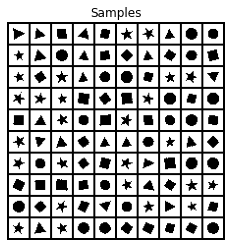

In [9]:
show_samples(shapes_train[:100])

In [10]:
H, W, _ = shapes_train[0].shape
model = PixelCNN((1, H, W)).to(device)
train_losses, test_losses, shapes_model = train_model(shapes_train, shapes_test, model)

epoch 0 started
train loss: 0.4669934772863621, test_loss: 0.19801616668701172
epoch 1 started
train loss: 0.3182763552702055, test_loss: 0.1463431417942047
epoch 2 started
train loss: 0.25932542319462554, test_loss: 0.13282184302806854
epoch 3 started
train loss: 0.22632152643963332, test_loss: 0.12214477360248566
epoch 4 started
train loss: 0.20416129871112546, test_loss: 0.1065763384103775
epoch 5 started
train loss: 0.18768328699336304, test_loss: 0.10002107918262482
epoch 6 started
train loss: 0.17470616770694064, test_loss: 0.09238937497138977
epoch 7 started
train loss: 0.16435767041246702, test_loss: 0.09012642502784729
epoch 8 started
train loss: 0.15556158252605579, test_loss: 0.08036915212869644
epoch 9 started
train loss: 0.14798940544629968, test_loss: 0.07730314880609512


In [11]:
def show_train_plots(train_losses, test_losses, title):
    plt.figure()
    n_epochs = len(test_losses) - 1
    x_train = np.linspace(0, n_epochs, len(train_losses))
    x_test = np.arange(n_epochs + 1)

    plt.plot(x_train, train_losses, label='train loss')
    plt.plot(x_test, test_losses, label='test loss')
    plt.legend()
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('NLL')
    plt.show()

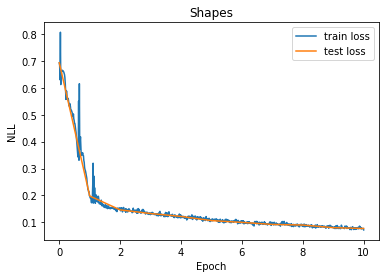

In [12]:
show_train_plots(train_losses, test_losses, 'Shapes')

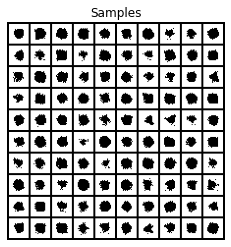

In [13]:
samples = shapes_model.sample(100)
show_samples(samples)

### Second dataset: MNIST (5 points)

In [14]:
# For colab users: download file
! wget https://github.com/egiby/Generative-Models-MIPT/raw/hw1/module1-likelihood/mnist.pkl

--2022-03-15 16:44:39--  https://github.com/egiby/Generative-Models-MIPT/raw/hw1/module1-likelihood/mnist.pkl
Resolving github.com (github.com)... 13.114.40.48
Connecting to github.com (github.com)|13.114.40.48|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/egiby/Generative-Models-MIPT/hw1/module1-likelihood/mnist.pkl [following]
--2022-03-15 16:44:39--  https://raw.githubusercontent.com/egiby/Generative-Models-MIPT/hw1/module1-likelihood/mnist.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55440407 (53M) [application/octet-stream]
Saving to: ‘mnist.pkl.1’

mnist.pkl.1         100%[===================>]  52.87M   162MB/s    in 0.3s    

2022-03-15 16:44:40 (162 MB/s) - ‘mnist.pkl.1’ saved

In [15]:
mnist_train, mnist_test = load_data('./mnist.pkl')

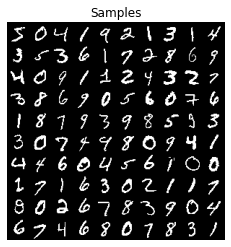

In [16]:
show_samples(mnist_train[:100])

In [17]:
H, W, _ = mnist_train[0].shape
model = PixelCNN((1, H, W))
train_losses, test_losses, mnist_model = train_model(mnist_train, mnist_test, model)

epoch 0 started
train loss: 0.16474417816283607, test_loss: 0.09427855163812637
epoch 1 started
train loss: 0.12769570986408668, test_loss: 0.08852028846740723
epoch 2 started
train loss: 0.08952836596220731, test_loss: 0.0875047817826271
epoch 3 started
train loss: 0.08692173259705305, test_loss: 0.0848291665315628
epoch 4 started
train loss: 0.08528344508260488, test_loss: 0.08355145156383514
epoch 5 started
train loss: 0.08414679769426585, test_loss: 0.08239258080720901
epoch 6 started
train loss: 0.08337233076244592, test_loss: 0.08209876716136932
epoch 7 started
train loss: 0.08271553799510002, test_loss: 0.08151180297136307
epoch 8 started
train loss: 0.08212438438087702, test_loss: 0.08108814805746078
epoch 9 started
train loss: 0.08159815734624863, test_loss: 0.0818847045302391


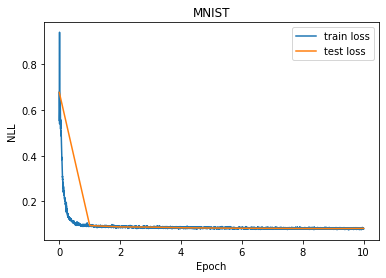

In [18]:
show_train_plots(train_losses, test_losses, 'MNIST')

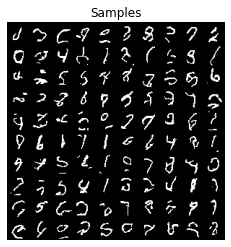

In [19]:
samples = mnist_model.sample(100)
show_samples(samples)